Discrete time arrival model

This program models a market of mutually exclusive buyers and sellers where:
- their entrances into the market are Poisson arrival processes,
- they leave the market only after engaging in a transaction
- their behavior follows expected utility theory, and
- the utility of the product over time is random (i.e. there is a mortality rate that is affected by the product in a known way)

Model specification options:
- linear EU / risk-averse EU / prospect utility theory
- rational / real probability weighting
- exponential / hyperbolic time discounting


In [2]:
import numpy as np
import clearing_price
from matplotlib import pyplot as plt
import dynarray
import scipy as sp

In [138]:
time_horizon = 50
time_step = 1/12
expected_buyer_arrivals = 10 #50000/1000
expected_seller_arrivals = 10 #6000/1000

mortality = lambda age : np.exp(0.085 * age) / np.exp(0.085 * 100)
mortality_dialysis = lambda age : (np.exp(0.085 * age) + 0.15) / (np.exp(0.085 * 100) + 0.15)
mortality_donor = lambda age : (np.exp(0.085 * age) + 0.01) / (np.exp(0.085 * 100) + 0.01)
#time_discounting = lambda future_time : np.exp(-np.log(1/0.98) * future_time) # exponential discounting
time_discounting = lambda future_time : 1/(1 + np.log(1/0.98) * future_time) # hyperbolic discounting

# list of data:
# - time
# - number of buyers in market
# - number of sellers in market
# - cumulative buyers
# - cumulative sellers
# - total deals made
# - clearing price
# - average successful buyer age
results_log = np.zeros(shape=(int(time_horizon/time_step), 7))
results_log[0] =[0, 0, 0, 0, 0, 0, np.nan]
cumulative_buyers = 0
cumulative_sellers = 0
cumulative_deals = 0

agents = dynarray.DynamicArray((None, 5))
total_steps = int(time_horizon/time_step)
ages = np.linspace(0,100,100+1)
for step in range(total_steps):
    # a poisson distribution number of buyers and sellers arrive
    for i in range(np.random.poisson(lam=expected_buyer_arrivals*time_step)):
        buyer_age = sp.stats.gompertz.rvs(0.000167, -44.0416, 11.756)
        while (buyer_age < 0): buyer_age = sp.stats.gompertz.rvs(0.000167, -44.0416, 11.756)
        agents.append(np.array([
            1, # is buyer
            buyer_age, # age
            np.random.normal(3000,500), # year_value
            0, # initial valuation
            0, # mortality dummy
        ]))
        cumulative_buyers += 1
    for i in range(np.random.poisson(lam=expected_seller_arrivals*time_step)):
        agents.append(np.array([
            0, # is buyer
            np.random.uniform(18,60), # age
            np.random.normal(3000,500), # year_value
            0, # initial valuation
            0, # mortality dummy
        ]))
        cumulative_sellers += 1
    
    # derive valuations for each buyer and seller
    # integrate year_value * mortality * time_discounting
    for i in range(agents.shape[0]):
        if agents[i,0] == 1:
            agents[i,3] = agents[i,2] * sp.integrate.quad(lambda age : time_discounting(age-agents[i,1]) * ((1-mortality(age)) - (1-mortality_dialysis(age))), agents[i,1], 100)[0] + np.random.normal(0,0.001)
        else:
            agents[i,3] = agents[i,2] * sp.integrate.quad(lambda age : time_discounting(age-agents[i,1]) * ((1-mortality(age)) - (1-mortality_donor(age))), agents[i,1], 100)[0] + np.random.normal(0,0.001)

    avg_successful_buyer_age = np.nan
    if agents.shape[0] > 0:
        # clear the market
        prior_size = agents.shape[0]
        price = clearing_price.find_median_clearing_price(agents[agents[:,0] == 1,3], agents[agents[:,0] != 1,3])
        if price:
            avg_successful_buyer_age = np.mean(agents[((agents[:,0] == 1) & (agents[:,3] >= price))][:,1])
            agents = dynarray.DynamicArray(agents[((agents[:,0] == 1) & (agents[:,3] < price)) | ((agents[:,0] != 1) & (agents[:,3] > price))])
        cumulative_deals += (prior_size - agents.shape[0])/2
        
        # update ages of existing buyers and sellers
        agents[:,1] += time_step
        # kill off buyers and sellers according to mortality rate
        agents[:,4] = np.random.random(size=agents.shape[0])
        agents = dynarray.DynamicArray(agents[
            (
                (agents[:,0] == 1) & (agents[:,4] > mortality_dialysis(agents[:,1]))
            ) | (
                (agents[:,0] != 1) & (agents[:,4] > mortality(agents[:,1]))
            )
        ])

    results_log[step] = ([
        np.sum(agents[:,0] == 1),
        np.sum(agents[:,0] == 0),
        cumulative_buyers,
        cumulative_sellers,
        cumulative_deals,
        price,
        avg_successful_buyer_age,
    ])

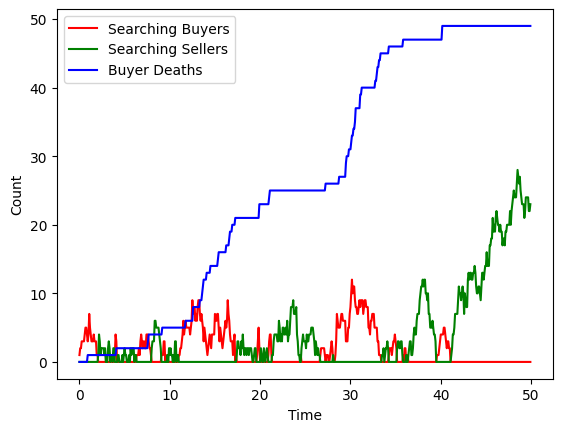

In [139]:
time_axis = np.arange(0, time_horizon, time_step)
plt.plot(time_axis, results_log[:,0], "r-", label="Searching Buyers")
plt.plot(time_axis, results_log[:,1], "g-", label="Searching Sellers")
# plt.plot(time_axis, results_log[:,2], "r--", label="Cumulative Buyers")
# plt.plot(time_axis, results_log[:,3], "g--", label="Cumulative Sellers")
plt.plot(time_axis, results_log[:,2] - results_log[:,4] - results_log[:,0], "b-", label="Buyer Deaths")
plt.xlabel("Time")
plt.ylabel("Count")
plt.legend()
plt.show()

Text(0, 0.5, 'Avg age of successful buyer')

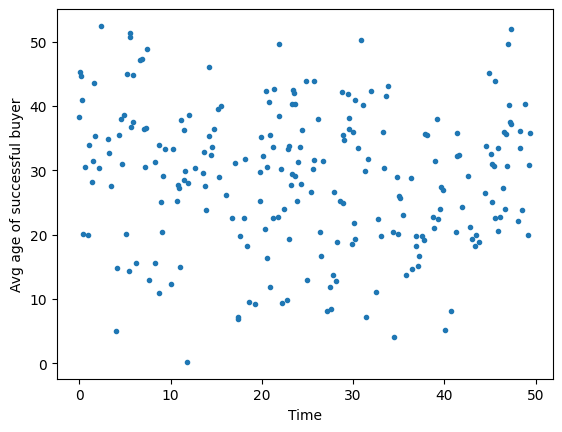

In [136]:
plt.scatter(time_axis, results_log[:,6], marker=".")
plt.xlabel("Time")
plt.ylabel("Avg age of successful buyer")

Text(0, 0.5, 'Value')

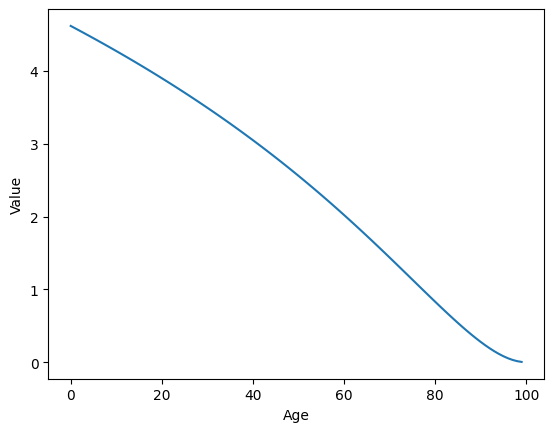

In [137]:
values = []
for curr_age in range(100):
    values.append(3000 * sp.integrate.quad(lambda age : time_discounting(age-curr_age) * ((1-mortality(age)) - (1-mortality_dialysis(age))), curr_age, 100)[0])
plt.plot(values)
plt.xlabel("Age")
plt.ylabel("Value")